In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("mental_health_social_media_dataset.csv")
df.head()

,person_name,age,date,gender,platform,daily_screen_time_min,social_media_time_min,negative_interactions_count,positive_interactions_count,sleep_hours,physical_activity_min,anxiety_level,stress_level,mood_level,mental_state
0,Reyansh Ghosh,35,1/1/2024,Male,Instagram,320,160,1,2,7.4,28,2,7,6,Stressed
1,Neha Patel,24,1/12/2024,Female,Instagram,453,226,1,3,6.7,15,3,8,5,Stressed
2,Ananya Naidu,26,1/6/2024,Male,Snapchat,357,196,1,2,7.2,24,3,7,6,Stressed
3,Neha Das,66,1/17/2024,Female,Snapchat,190,105,0,1,8.0,41,2,6,6,Stressed
4,Reyansh Banerjee,31,1/28/2024,Male,Snapchat,383,211,1,2,7.1,22,3,7,6,Stressed


In [15]:
# Nettoyage du dataset selon les consignes du projet
print("Suppression des colonnes anxiété, stress, humeur, nom de la personne et date pour eviter la fuite de données")
print("Colonnes avant nettoyage:", df.columns.tolist())

# Supprimer les colonnes demandées
columns_to_drop = ['person_name', 'date', 'anxiety_level', 'stress_level', 'mood_level']
columns_to_drop = [col for col in columns_to_drop if col in df.columns]

if columns_to_drop:
    df = df.drop(columns=columns_to_drop)
    print("\nColonnes après nettoyage:", df.columns.tolist())

else: 
    print("\nColonnes après nettoyage:", df.columns.tolist())
    print("Aucune colonne à supprimer")

df.head()

Suppression des colonnes anxiété, stress, humeur, nom de la personne et date pour eviter la fuite de données
Colonnes avant nettoyage: ['age', 'gender', 'platform', 'daily_screen_time_min', 'social_media_time_min', 'negative_interactions_count', 'positive_interactions_count', 'sleep_hours', 'physical_activity_min', 'mental_state']

Colonnes après nettoyage: ['age', 'gender', 'platform', 'daily_screen_time_min', 'social_media_time_min', 'negative_interactions_count', 'positive_interactions_count', 'sleep_hours', 'physical_activity_min', 'mental_state']
Aucune colonne à supprimer


,age,gender,platform,daily_screen_time_min,social_media_time_min,negative_interactions_count,positive_interactions_count,sleep_hours,physical_activity_min,mental_state
0,35,Male,Instagram,320,160,1,2,7.4,28,Stressed
1,24,Female,Instagram,453,226,1,3,6.7,15,Stressed
2,26,Male,Snapchat,357,196,1,2,7.2,24,Stressed
3,66,Female,Snapchat,190,105,0,1,8.0,41,Stressed
4,31,Male,Snapchat,383,211,1,2,7.1,22,Stressed


In [2]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   person_name                  5000 non-null   str    
 1   age                          5000 non-null   int64  
 2   date                         5000 non-null   str    
 3   gender                       5000 non-null   str    
 4   platform                     5000 non-null   str    
 5   daily_screen_time_min        5000 non-null   int64  
 6   social_media_time_min        5000 non-null   int64  
 7   negative_interactions_count  5000 non-null   int64  
 8   positive_interactions_count  5000 non-null   int64  
 9   sleep_hours                  5000 non-null   float64
 10  physical_activity_min        5000 non-null   int64  
 11  anxiety_level                5000 non-null   int64  
 12  stress_level                 5000 non-null   int64  
 13  mood_level                   

In [3]:
df.describe()

,age,daily_screen_time_min,social_media_time_min,negative_interactions_count,positive_interactions_count,sleep_hours,physical_activity_min,anxiety_level,stress_level,mood_level
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,29.947800,373.058200,175.331600,0.864200,1.835400,7.134660,22.693400,2.510400,7.107600,5.625800
std,12.279936,106.003916,71.209329,0.555176,0.943443,0.533184,10.602862,0.794996,1.062378,0.759928
min,13.000000,140.000000,35.000000,0.000000,0.000000,6.400000,8.000000,1.000000,5.000000,4.000000
25%,21.000000,310.000000,118.000000,1.000000,1.000000,6.700000,14.000000,2.000000,6.000000,5.000000
50%,27.000000,388.000000,170.000000,1.000000,2.000000,7.100000,21.000000,3.000000,7.000000,6.000000
75%,35.250000,461.000000,231.000000,1.000000,2.000000,7.450000,29.000000,3.000000,8.000000,6.000000
max,69.000000,520.000000,338.000000,2.000000,4.000000,8.300000,46.000000,4.000000,9.000000,7.000000


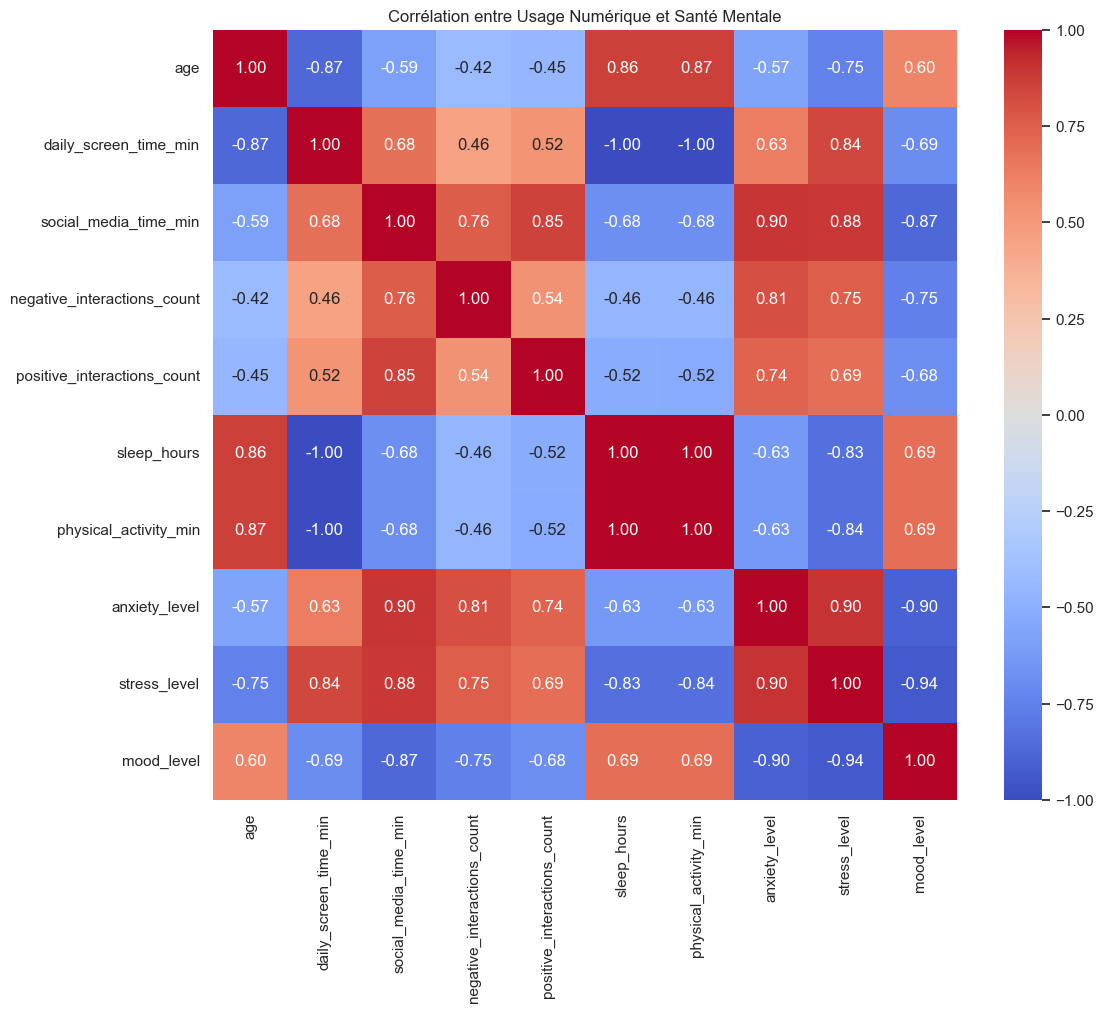

In [4]:
# Configuration du style
sns.set_theme(style="whitegrid")

# Sélection des colonnes numériques pour la corrélation
numeric_cols = [
    'age', 'daily_screen_time_min', 'social_media_time_min',
    'negative_interactions_count', 'positive_interactions_count',
    'sleep_hours', 'physical_activity_min', 
    'anxiety_level', 'stress_level', 'mood_level'
]

plt.figure(figsize=(12, 10))
correlation_matrix = df[numeric_cols].corr()

# Heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Corrélation entre Usage Numérique et Santé Mentale")
plt.show()


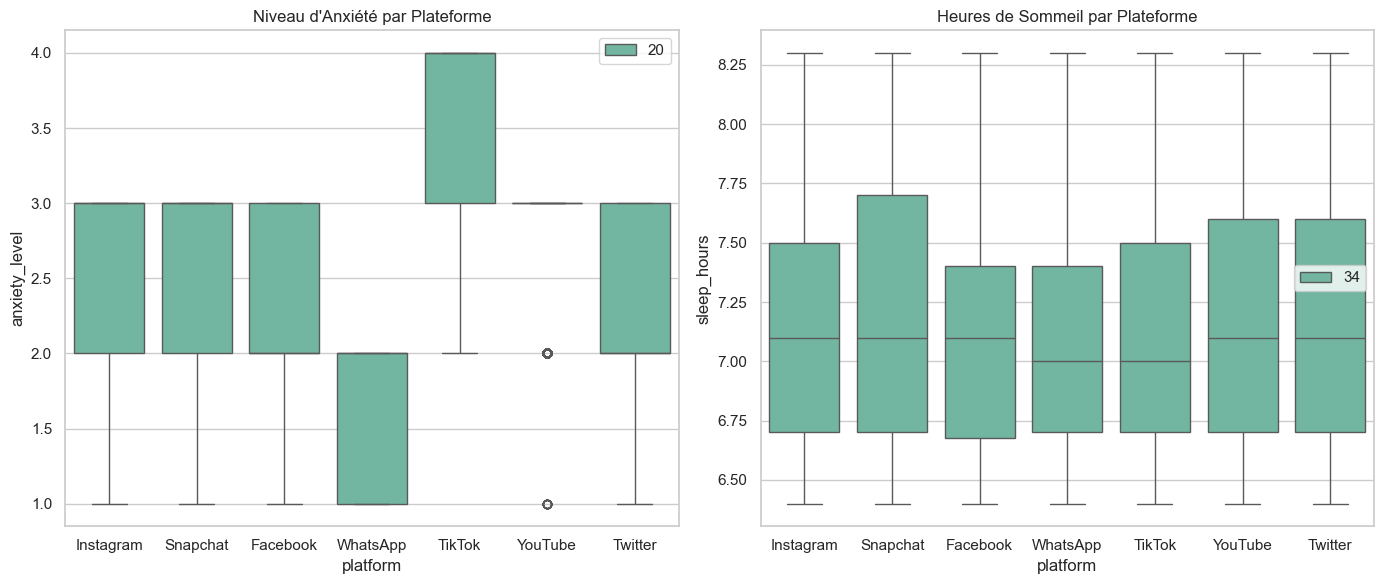

In [5]:
plt.figure(figsize=(14, 6))

# Boxplot du niveau d'anxiété par plateforme
plt.subplot(1, 2, 1)
sns.boxplot(x='platform', y='anxiety_level',legend='auto', data=df, palette="Set2",hue=20)
plt.title("Niveau d'Anxiété par Plateforme")

# Boxplot des heures de sommeil par plateforme
plt.subplot(1, 2, 2)
sns.boxplot(x='platform', y='sleep_hours',legend='auto', data=df, palette="Set2",hue=34)
plt.title("Heures de Sommeil par Plateforme")

plt.tight_layout()
plt.show()


--- Rapport de Classification ---
              precision    recall  f1-score   support

     At_Risk       1.00      1.00      1.00        12
     Healthy       1.00      1.00      1.00        73
    Stressed       1.00      1.00      1.00       915

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



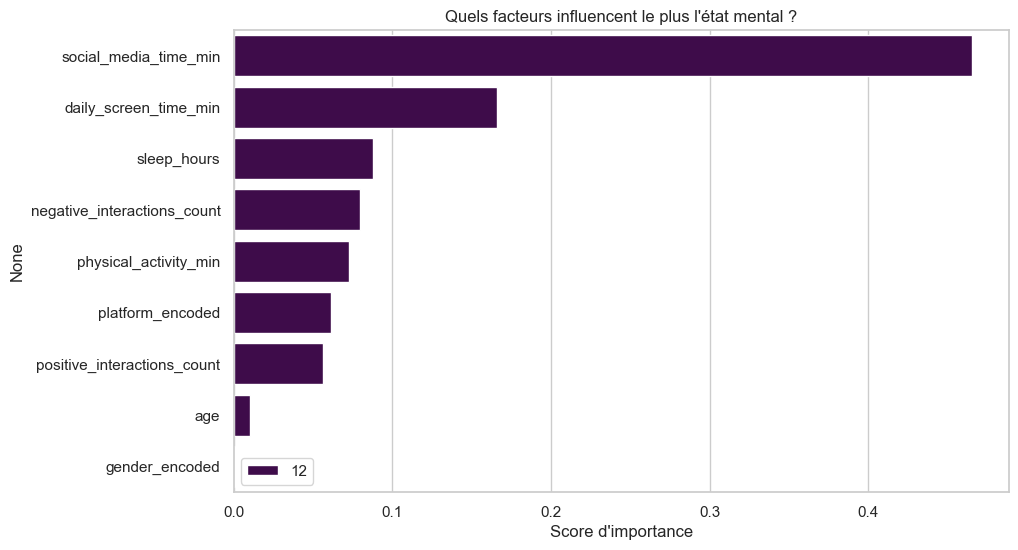

In [21]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# 1. Encodage des variables catégorielles (Gender, Platform)
le_gender = LabelEncoder()
la_platform = LabelEncoder()
# On garde une copie pour le ML
df_ml = df.copy()
df_ml['gender_encoded'] = le_gender.fit_transform(df_ml['gender'])
df_ml['platform_encoded'] = la_platform.fit_transform(df_ml['platform'])

# 2. Définition des features (X) et de la cible (y)
# On retire les colonnes "résultats" trop évidentes (anxiety_level, stress_level, mood_level) 
# pour voir si l'usage SEUL peut prédire l'état mental.
features = [
    'age', 'gender_encoded', 'platform_encoded', 
    'daily_screen_time_min', 'social_media_time_min',
    'negative_interactions_count', 'positive_interactions_count',
    'sleep_hours', 'physical_activity_min'
]
target = 'mental_state'

X = df_ml[features]
y = df_ml[target]

# 3. Séparation Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Entraînement du modèle
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 5. Évaluation
y_pred = model.predict(X_test)
print("--- Rapport de Classification ---")
print(classification_report(y_test, y_pred))

# 6. Importance des variables
feature_imp = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_imp, y=feature_imp.index, palette="viridis",hue=12)
plt.title("Quels facteurs influencent le plus l'état mental ?")
plt.xlabel("Score d'importance")
plt.show()
